# 2. Mehrschichtiges feedforward-Netz
Nachfolgend sollen die Methoden `feedForward`, `backPropagation` vervollständigt werden.
Um die Implementierungen zu prüfen, können die Methoden `checkFeedForward` und `checkBackPropagation` verwendet werden.
Anschließend werden verschiedene Architekturen (Layer, Anzahl Neuronen, Aktivierungsfunktionen, Batch-Sizes, Learningrates) manuell ausgetestet werden, um für die Beispiel-Funktionen optimale Ergebnisse zu erzielen. Danach folgt eine Implementierung mit `torch.nn`, `torch.autograd` und `torch.optim` und ein weiterer Test der Architekturen. Abschließend werden alternatvie Optimierungsalgorithmen ausgetestet.

# 2.1 Implementierung Backpropagation

In [163]:
import torch
import math
%matplotlib inline
# Mehrschichtiges Neuronalels Netzwerk
# Eingaben:
#   layers: Anzahl an Neuronen pro Layer
#   activations: verwendete Aktivierungsfunktionen pro Layer
class NeuralNetwork(object):
    def __init__(self, layers = [1 , 10, 1], activations=['sigmoid', 'sigmoid']):
        assert(len(layers) == len(activations)+1)
        self.layers = layers
        self.activations = activations
        self.weights = [] # Shape in Layer-i [Neuronen in i, Neuronen in i+1]
        self.biases = []  # Shape in Layer-i [1, Neuronen in i+1]
        
        # Initialisieren der Gewichte und Bias pro Layer mit Zufallswerten
        for i in range(len(layers)-1):
            self.weights.append(self.initializeWeight(layers[i], layers[i+1], self.activations[i]))
            self.biases.append(self.initializeWeight(1, layers[i+1], self.activations[i]))
    
    def initializeWeight(self, outputDim, inputDim, name):
        if(name == 'sigmoid'):
            return torch.randn(outputDim, inputDim)
        elif(name == 'linear'):
            tensor = torch.empty(outputDim, inputDim)
            torch.nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))
            return tensor
        elif(name == 'relu'):
            return torch.randn(outputDim, inputDim)*math.sqrt(2/inputDim)
        elif(name == 'tanh'):
            return torch.randn(outputDim, inputDim)*math.sqrt(1/inputDim)
        else:
            print('Unbekannte Aktivierungsfunktion. linear wird verwendet')
            tensor = torch.empty(outputDim, inputDim)
            torch.nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))
            return tensor
    
    def getActivationFunction(self, name):
        if(name == 'sigmoid'):
            return lambda x : torch.exp(x)/(1+torch.exp(x))
        elif(name == 'linear'):
            return lambda x : x
        elif(name == 'relu'):
            def relu(x):
                y = torch.clone(x)
                y[y<0] = 0
                return y
            return relu
        elif(name == 'tanh'):
            return lambda x : torch.tanh(x)
        else:
            print('Unbekannte Aktivierungsfunktion. linear wird verwendet')
            return lambda x: x

    def getDerivitiveActivationFunction(self, name):
        if(name == 'sigmoid'):
            sig = lambda x : torch.exp(x)/(1+torch.exp(x))
            return lambda x :sig(x)*(1-sig(x)) 
        elif(name == 'linear'):
            return lambda x: 1
        elif(name == 'relu'):
            def relu_diff(x):
                y = torch.clone(x)
                y[y>=0] = 1
                y[y<0] = 0
                return y
            return relu_diff
        elif(name == 'tanh'):
            return lambda x : 1 - torch.tanh(x)**2
        else:
            print('Unbekannte Aktivierungsfunktion. linear wird verwendet')
            return lambda x: 1
    
    def predict(self, X):
        (_, a_s) = self.feedForward(X)
        return a_s[-1]
    
    # Berechnung der Ausgaben
    # Es werden alle Summen vor und nach der Aktivierungsfunktion pro Layer zurückgegeben,
    # damit sie für die Backpropagation benutzt werden künenn
    # Eingaben:
    #   x: Eingabe an den ersten Layer [batch_size, 1]
    # Ausgaben:
    #   z_s: Summen (vor Aktivierungsfunktion) pro Layer, [batch_size, Neuronen in Layer i] 
    #   a_s: Ausgaben pro Layer, [batch_size, Neuronen in Layer i] 
    def feedForward(self, x):
        a = x.clone()
        z_s = []
        a_s = [a] 
                      
        for l in range(len(self.weights)):
            z_s.append(a.mm(self.weights[l]) + self.biases[l])
            activationFunction = self.getActivationFunction(self.activations[l])
            a_s.append(activationFunction(z_s[-1]))
            a = a_s[-1]

        return (z_s, a_s)
    
    # Backpropagation
    # Zurückverteilen der Deltas an die Gewichte und Biases
    # Eingaben:
    #   z_s: Summen (vor Aktivierungsfunktion) pro Layer, [batch_size, Neuronen in Layer i] 
    #   a_s: Ausgaben pro Layer, [batch_size, Neuronen in Layer i] 
    # Ausgaben:
    #   dw: Ableitungen bezüglich der Gewichte pro Layer, [batch_size, Neuronen in Layer i] 
    #   db: Ableitungen bezüglich der Biases pro Layer, [batch_size, 1] 
    def backPropagation(self, y, z_s, a_s):
            dw = []  # dC/dW
            db = []  # dC/dB
            deltas = [None] * len(self.weights)  # delta = dC/dZ Fehler pro Layer
            # Füllen des Fehlers im letzten Layer anhand der erwarteten Ausgaben des Netzwerks
            deltas[-1] = (y-a_s[-1])*(self.getDerivitiveActivationFunction(self.activations[-1])(z_s[-1]))
                       
            # Ausführen der Backpropagation
            # Füllen des Fehlers im Layer anhand der bisherigen Deltas
            
            for k in reversed(range(len(deltas)-1)):
                deltas[k] = deltas[k+1].mm(self.weights[k+1].T)*(self.getDerivitiveActivationFunction(self.activations[k])(z_s[k]))
                
            batch_size = y.shape[0]
            # Bestimmen der Gewichtsänderung
            db = [torch.ones(1, batch_size).mm(d/float(batch_size)) for d in deltas]
            dw = [a_s[i].T.mm(d)/float(batch_size) for i,d in enumerate(deltas)]

            # Rückgabe der Ableitungen bezüglich der Gewichte und Biases
            return dw, db

    # Aktualisieren der Gewichte und Bias anhand der Ausgabe in mehreren Batches und Epochen
    def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
            for e in range(epochs): 
                i=0
                while(i<len(y)):
                    x_batch = x[i:i+batch_size]
                    y_batch = y[i:i+batch_size]
                    i = i+batch_size
                    z_s, a_s = self.feedForward(x_batch)
                    dw, db = self.backPropagation(y_batch, z_s, a_s)
                    self.weights = [w+lr*dweight for w,dweight in zip(self.weights, dw)]
                    self.biases = [w+lr*dbias for w,dbias in zip(self.biases, db)]
                    batch_loss = torch.norm(a_s[-1]-y_batch)
            


In [34]:
def createSampleNeuralNetwork():
    nn = NeuralNetwork(layers = [2 , 10, 1], activations=['sigmoid', 'sigmoid'])
    
    # Feste Gewichte und Bias setzen, damit das Ergebnis immer gleich ist.
    nn.weights = [
        torch.tensor([
            [ 0.1397, -0.5724,  0.2194, -3.0984,  0.6770, -0.3220,  1.4311,  0.0931, -0.7618,  0.6987],
            [ 0.7182,  2.8919, -1.9848, -0.2261, -1.1376, -0.0176, -0.2824, -1.6781, -1.1798, -1.5255]
        ]),
        torch.tensor([
            [ 3.0417],
            [-1.1143],
            [-2.2069],
            [-1.1303],
            [ 0.5879],
            [ 0.5013],
            [ 1.1043],
            [ 0.8942],
            [-1.3571],
            [ 0.7487]
        ])
    ]
    
    nn.biases = [
        torch.tensor([
            [ 0.7933,  0.5149, -1.4123,  0.6115,  0.0221, -1.2227,  1.4272, -0.9937, -0.5665, -0.6665]
        ]),
        torch.tensor([
            [-1.6589]]
        )
    ]
    
    return nn

In [35]:
def checkFeedForward():
    nn = createSampleNeuralNetwork()
    
    # Feste Eingabewerte für den Test
    X = torch.tensor([
        [ 0.1397,  0.7182],
        [-0.5724,  2.8919]
    ]).T
    
    # Eingaben mit den Gewichten verarbeiten
    a_s = nn.predict(X)
    
    # Erwartete Ausgabe des letzten Layers
    expected = torch.tensor([
            [0.4855000078678131, 0.7422999739646912]
    ]).T
    
    assert(torch.allclose(expected, a_s, rtol = 1e-04, atol = 1e-04))
    
checkFeedForward()
    

In [36]:
def checkBackPropagation():
    nn = createSampleNeuralNetwork()
    
     # Feste Eingabewerte für den Test
    X = torch.tensor([
        [ 0.1397, -0.5724],
        [ 0.7182,  2.8919]
    ])

    
    Y = torch.tensor([
        [0.8000],
        [0.1000]
    ])
    
    # Eingaben mit den Gewichten verarbeiten
    z_s, a_s = nn.feedForward(X)
    
    # Deltas bestimmen
    dw, db = nn.backPropagation(Y, z_s, a_s)
    
    dwExpected = [
        torch.tensor([
            [-0.0022, -0.0011, -0.0029,  0.0027, -0.0007, -0.0028, -0.0059,  0.0011, -0.0012,  0.0007],
            [-0.0415,  0.0044,  0.0126,  0.0233, -0.0086, -0.0152, -0.0298, -0.0055, 0.0102, -0.0055]
        ]),
        torch.tensor([
            [-0.0349],
            [-0.0525],
            [ 0.0172],
            [ 0.0169],
            [ 0.0232],
            [-0.0025],
            [-0.0178],
            [ 0.0193],
            [ 0.0190],
            [ 0.0220]
        ])   
    ]
    
    dbExpected = [
        torch.tensor([
            [ 0.0200, -0.0077, -0.0212, -0.0049,  0.0030, -0.0012, -0.0039,  0.0086, -0.0124,  0.0067]
        ]),
        torch.tensor([
            [-0.0222]
        ])
    ]
    
    
    assert(torch.allclose(dw[0], dwExpected[0], rtol = 1e-04, atol = 1e-04))
    assert(torch.allclose(dw[1], dwExpected[1], rtol = 1e-04, atol = 1e-04))
    assert(torch.allclose(db[0], dbExpected[0], rtol = 1e-04, atol = 1e-04))    
    assert(torch.allclose(db[1], dbExpected[1], rtol = 1e-04, atol = 1e-04))
    
checkBackPropagation()


# 2.2 Optimierung der Hyperparameter

In [ ]:
# import matplotlib.pyplot as plt
def sinus(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    # TODO optimales Netzwerk ermitteln
    sinus_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    # sin
    sinus_X = 2*math.pi*torch.rand(2000).reshape(-1, 1)
    # Je nach Ausgangslayer, muss ggf. eine Transformation sattfinden
    # Der Sigmoid hat z.B einen Wertebereich von (0,1) und könnte somit,
    # negativen Werte des Sinus nicht darstellen.
    sinus_y = (torch.sin(sinus_X) + 1) / 2

    return sinus_nn.train(sinus_X, sinus_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)

# #print(y, X)
# plt.scatter(sinus_X.flatten(), sinus_y.flatten())
# plt.scatter(sinus_X.flatten(), sinus_a_s.flatten())
# plt.show()

In [ ]:
def linear1(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear1_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    nlinear1_X = 3*torch.rand(2000).reshape(-1, 1)
    nlinear1_y = torch.clone(nlinear_X)
    nlinear1_y[nlinear1_y>=2] = 2
    nlinear1_y[nlinear1_y<1] = 1

    return nlinear1_nn.train(nlinear1_X, nlinear1_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)


#print(y, X)
# plt.scatter(nlinear_X.flatten(), nlinear_y.flatten())
# plt.scatter(nlinear_X.flatten(), nlinear_a_s.flatten())
# plt.show()

In [ ]:
def linear2(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear2_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    nlinear2_X = 3*torch.rand(2000).reshape(-1, 1)
    nlinear2_y = torch.clone(nlinear2_X)
    nlinear2_y[nlinear2_y>=1.5] = 2
    nlinear2_y[nlinear2_y<1.5] = 1

    return nlinear2_nn.train(nlinear2_X, nlinear2_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)

In [ ]:
def linear3(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear3_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    nlinear3_X = 1.14*torch.rand(2000).reshape(-1, 1)
    nlinear3_y = (10*nlinear3_X**5 - 8*nlinear3_X**4 - 6*nlinear3_X**3 + 4*nlinear3_X**2 - 2*nlinear3_X + 2.3) / 2.5

    return nlinear3_nn.train(nlinear3_X, nlinear3_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)

In [ ]:
def linear4(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear4_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    nlinear4_X = 1.14*torch.rand(2000).reshape(-1, 1)
    nlinear4_y = (10*nlinear4_X**5 - 8*nlinear4_X**4 - 6*nlinear4_X**3 + 4*nlinear4_X**2 - 2*nlinear4_X + 2.3) / 2.5

    return nlinear4_nn.train(nlinear4_X, nlinear4_y,  batch_size=batchsize, epochs=epochsize, lr = learning_rate)

In [ ]:
import numpy
import pandas as pd

actfunction = ["sigmoid", "relu", "tanh", "linear"]

for i in range(len(actfunction)):
    for batchsize in range(1, 302, 100):
        for epochsize in range(1, 302, 100):
            for learning_rate in numpy.arange(0.01, 0.92, 0.3):
                for hidden_layers in range(1, 122, 40):
                    loss = linear1(actfunction[i], batchsize, epochsize, learning_rate, hidden_layers)
                    loss2 = linear2(actfunction[i], batchsize, epochsize, learning_rate, hidden_layers)
                    loss3 = linear3(actfunction[i], batchsize, epochsize, learning_rate, hidden_layers)
                    loss4 = linear4(actfunction[i], batchsize, epochsize, learning_rate, hidden_layers)
                    loss_sinus = linear4(actfunction[i], batchsize, epochsize, learning_rate, hidden_layers)
                    df = pd.DataFrame({"activation_function": [actfunction[i]], "batchsize": [batchsize], "epochsize": [epochsize], "learning_rate": [learning_rate], "hidden_layers": [hidden_layers],"loss": [loss.item()]})
                    df2 = pd.DataFrame({"activation_function": [actfunction[i]], "batchsize": [batchsize], "epochsize": [epochsize], "learning_rate": [learning_rate], "hidden_layers": [hidden_layers],"loss": [loss2.item()]})
                    df3 = pd.DataFrame({"activation_function": [actfunction[i]], "batchsize": [batchsize], "epochsize": [epochsize], "learning_rate": [learning_rate], "hidden_layers": [hidden_layers],"loss": [loss3.item()]})
                    df4 = pd.DataFrame({"activation_function": [actfunction[i]], "batchsize": [batchsize], "epochsize": [epochsize], "learning_rate": [learning_rate], "hidden_layers": [hidden_layers],"loss": [loss4.item()]})
                    df.to_csv("C://Uni/stats_linear1.csv", mode='a', header=False, index=False)
                    df2.to_csv("C://Uni/stats_linear2.csv", mode='a', header=False, index=False)
                    df3.to_csv("C://Uni/stats_linear3.csv", mode='a', header=False, index=False)
                    df4.to_csv("C://Uni/stats_linear4.csv", mode='a', header=False, index=False)
                    

In [48]:
import pandas as pd

files = ["C://Uni//stats_sinus.csv", "C://Uni//stats_linear1.csv", "C://Uni//stats_linear2.csv", "C://Uni//stats_linear3.csv", "C://Uni//stats_linear4.csv", ]
frames = []

for file in range(len(files)):
    df = pd.read_csv(files[file])
    headers = ["activation_function", 'batchsize', 'epochsize', 'learning_rate', 'hidden_layers', "loss"]
    df.columns = headers 
    frames.append((files[file],df))

for frame in frames:
    min_lines = frame[1][frame[1].loss != 0].nsmallest(3, ["loss"])
    print(f"The least loss in file {os.path.basename(frame[0])} was achieved with:")
    print(min_lines.to_string(index=False))
    print("----------------------------------------------------------------------------------")


The least loss in file stats_sinus.csv was achieved with:
activation_function  batchsize  epochsize  learning_rate  hidden_layers      loss
               relu          1        201           0.31             41  0.000298
            sigmoid          1        201           0.91            121  0.000776
            sigmoid          1          1           0.91             81  0.001036
----------------------------------------------------------------------------------
The least loss in file stats_linear1.csv was achieved with:
activation_function  batchsize  epochsize  learning_rate  hidden_layers          loss
            sigmoid          1        301           0.61            121  1.192093e-07
            sigmoid          1        101           0.01            121  1.788139e-07
            sigmoid          1        301           0.31            121  2.980232e-07
----------------------------------------------------------------------------------
The least loss in file stats_linear2.csv was

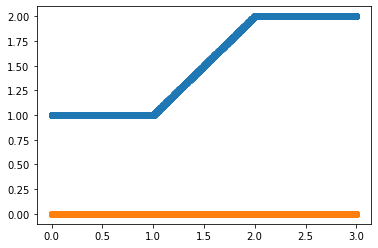

In [159]:
import matplotlib.pyplot as plt

def sinus(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    sinus_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    sinus_X = 2*math.pi*torch.rand(2000).reshape(-1, 1)
    sinus_y = (torch.sin(sinus_X) + 1) / 2

    sinus_nn.train(sinus_X, sinus_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)
    sinus_a_s = sinus_nn.predict(sinus_X)

    plt.scatter(sinus_X.flatten(), sinus_y.flatten())
    plt.scatter(sinus_X.flatten(), sinus_a_s.flatten())
    plt.show()

def linear1(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear1_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    nlinear1_X = 3*torch.rand(2000).reshape(-1, 1)
    nlinear1_y = torch.clone(nlinear1_X)
    nlinear1_y[nlinear1_y>=2] = 2
    nlinear1_y[nlinear1_y<1] = 1

    nlinear1_nn.train(nlinear1_X, nlinear1_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)
    nlinear1_a_s = nlinear1_nn.predict(nlinear1_X)
    
    plt.scatter(nlinear1_X.flatten(), nlinear1_y.flatten())
    plt.scatter(nlinear1_X.flatten(), nlinear1_a_s.flatten())
    plt.show()

def linear2(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear2_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    nlinear2_X = 3*torch.rand(2000).reshape(-1, 1)
    nlinear2_y = torch.clone(nlinear2_X)
    nlinear2_y[nlinear2_y>=1.5] = 2
    nlinear2_y[nlinear2_y<1.5] = 1

    nlinear2_nn.train(nlinear2_X, nlinear2_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)
    nlinear2_a_s = nlinear2_nn.predict(nlinear2_X)
    
    plt.scatter(nlinear2_X.flatten(), nlinear2_y.flatten())
    plt.scatter(nlinear2_X.flatten(), nlinear2_a_s.flatten())
    plt.show()

def linear3(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear3_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    nlinear3_X = 1.14*torch.rand(2000).reshape(-1, 1)
    nlinear3_y = (10*nlinear3_X**5 - 8*nlinear3_X**4 - 6*nlinear3_X**3 + 4*nlinear3_X**2 - 2*nlinear3_X + 2.3) / 2.5

    nlinear3_nn.train(nlinear3_X, nlinear3_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)
    nlinear3_a_s = nlinear3_nn.predict(nlinear3_X)
    
    plt.scatter(nlinear3_X.flatten(), nlinear3_y.flatten())
    plt.scatter(nlinear3_X.flatten(), nlinear3_a_s.flatten())
    plt.show()

def linear4(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear4_nn = NeuralNetwork(layers = [1, hidden_layers, 1], activations=[activation_function, activation_function])

    nlinear4_X = 1.14*torch.rand(2000).reshape(-1, 1)
    nlinear4_y = (10*nlinear4_X**5 - 8*nlinear4_X**4 - 6*nlinear4_X**3 + 4*nlinear4_X**2 - 2*nlinear4_X + 2.3) / 2.5

    nlinear4_nn.train(nlinear4_X, nlinear4_y,  batch_size=batchsize, epochs=epochsize, lr = learning_rate)
    nlinear4_a_s = nlinear4_nn.predict(nlinear4_X)
    
    plt.scatter(nlinear4_X.flatten(), nlinear4_y.flatten())
    plt.scatter(nlinear4_X.flatten(), nlinear4_a_s.flatten())
    plt.show()

sinus("relu", 1, 200, 0.3, 40)
linear1("sigmoid", 1, 100, 0.01, 120)
linear2("tanh", 1, 100, 0.3, 80)
linear3("sigmoid", 1, 300, 0.3, 121)
linear4("relu", 1, 200, 0.01, 121)

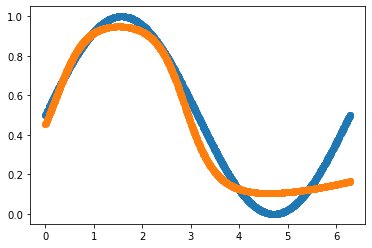

In [157]:
import matplotlib.pyplot as plt
# TODO optimales Netzwerk ermitteln
sinus_nn = NeuralNetwork(null)

# sin
sinus_X = 2*math.pi*torch.rand(2000).reshape(-1, 1)
# Je nach Ausgangslayer, muss ggf. eine Transformation sattfinden
# Der Sigmoid hat z.B einen Wertebereich von (0,1) und könnte somit,
# negativen Werte des Sinus nicht darstellen.
sinus_y = (torch.sin(sinus_X) + 1) / 2

sinus_nn.train(sinus_X, sinus_y, epochs=null, batch_size=null, lr = null)
sinus_a_s = sinus_nn.predict(sinus_X)
#print(y, X)
plt.scatter(sinus_X.flatten(), sinus_y.flatten())
plt.scatter(sinus_X.flatten(), sinus_a_s.flatten())
plt.show()

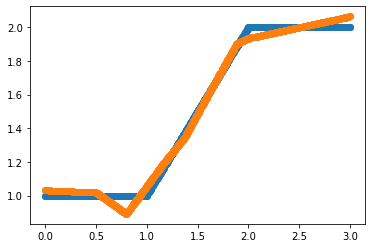

In [183]:
import matplotlib.pyplot as plt
# TODO optimales Netzwerk ermitteln
nlinear_nn = NeuralNetwork(layers=[1, 10, 10, 10, 1], activations=["linear", "relu", "relu", "relu"])

#activations=["tanh", "relu"]

nlinear_X = 3*torch.rand(2000).reshape(-1, 1)
nlinear_y = torch.clone(nlinear_X)
nlinear_y[nlinear_y>=2] = 2
nlinear_y[nlinear_y<1] = 1

nlinear_nn.train(nlinear_X, nlinear_y, batch_size=100, epochs=1000, lr = 0.001)
nlinear_a_s = nlinear_nn.predict(nlinear_X)
#print(y, X)
plt.scatter(nlinear_X.flatten(), nlinear_y.flatten())
plt.scatter(nlinear_X.flatten(), nlinear_a_s.flatten())
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# TODO optimales Netzwerk ermitteln
nlinear_nn = NeuralNetwork(null)

nlinear_X = 3*torch.rand(2000).reshape(-1, 1)
nlinear_y = torch.clone(nlinear_X)
nlinear_y[nlinear_y>=1.5] = 2
nlinear_y[nlinear_y<1.5] = 1

nlinear_nn.train(nlinear_X, nlinear_y, epochs=null, batch_size=null, lr = null)
nlinear_a_s = nlinear_nn.predict(nlinear_X)

plt.scatter(nlinear_X.flatten(), nlinear_y.flatten())
plt.scatter(nlinear_X.flatten(), nlinear_a_s.flatten())
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# TODO optimales Netzwerk ermitteln
nlinear_nn = NeuralNetwork(null)

nlinear_X = 1.14*torch.rand(2000).reshape(-1, 1)
nlinear_y = (10*nlinear_X**5 - 8*nlinear_X**4 - 6*nlinear_X**3 + 4*nlinear_X**2 - 2*nlinear_X + 2.3) / 2.5

nlinear_nn.train(nlinear_X, nlinear_y, epochs=null, batch_size=null, lr = null)
nlinear_a_s = nlinear_nn.predict(nlinear_X)

plt.scatter(nlinear_X.flatten(), nlinear_y.flatten())
plt.scatter(nlinear_X.flatten(), nlinear_a_s.flatten())
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# TODO optimales Netzwerk ermitteln
nlinear_nn = NeuralNetwork(null)

nlinear_X = 1.14*torch.rand(2000).reshape(-1, 1)
nlinear_y = (10*nlinear_X**5 - 8*nlinear_X**4 - 6*nlinear_X**3 + 4*nlinear_X**2 - 2*nlinear_X + 2.3) / 2.5

nlinear_nn.train(nlinear_X, nlinear_y, epochs=null, batch_size=null, lr = null)
nlinear_a_s = nlinear_nn.predict(nlinear_X)

plt.scatter(nlinear_X.flatten(), nlinear_y.flatten())
plt.scatter(nlinear_X.flatten(), nlinear_a_s.flatten())
plt.show()

# 2.3 Implementierung Backpropagation mit Autograd und Layern

In [154]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline
# Mehrschichtiges Neuronalels Netzwerk
# Eingaben:
#   layers: Anzahl an Neuronen pro Layer
#   activations: verwendete Aktivierungsfunktionen pro Layer
class NeuralNetworkTorch(nn.Module):
    def __init__(self, layers = [1, 100, 1], activations=['relu', 'relu']):
        super(NeuralNetworkTorch, self).__init__()
        assert(len(layers) == len(activations)+1)
        self.layers = layers
        self.activations = activations
        self.torchLayers = []

        # Initialisieren der Gewichte und Bias pro Layer mit Zufallswerten
        for i in range(len(layers)-1):
            a = nn.Linear(layers[i], layers[i+1])
            b = self.getActivationFunction(activations[i])
            self.torchLayers.append(a)
            self.torchLayers.append(b)
            self.add_module('layerLin' + str(i), a)
            self.add_module('layer' + str(i), b)
 
    def getActivationFunction(self, name):
        if(name == 'sigmoid'):
            return nn.Sigmoid()
        elif(name == 'linear'):
            return nn.Linear()
        elif(name == 'relu'):
            return nn.ReLU()
        elif(name == 'tanh'):
            return nn.Tanh()
        else:
            print('Unbekannte Aktivierungsfunktion. linear wird verwendet')
            return nn.Linear()
        
    def predict(self, X):
        return self.feedForward(X).detach()
    
    # Berechnung der Ausgaben
    # Es werden alle Summen vor und nach der Aktivierungsfunktion pro Layer zurückgegeben,
    # damit sie für die Backpropagation benutzt werden künenn
    # Eingaben:
    #   x: Eingabe an den ersten Layer
    # Ausgaben:
    #   a_s: Ausgaben pro Layer
    def feedForward(self, x):
        a = x.clone()

        for i in range(len(self.torchLayers)):
            a = self.torchLayers[i](a)
        return a        

    # Aktualisieren der Gewichte und Bias anhand der Ausgabe in mehreren Batches und Epochen
    def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
        criterion = torch.nn.MSELoss(reduction="mean")
        optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=10)
        a_s = []
        for e in range(epochs): 
            print("Epoche",e+1,"von",epochs)
            i=0
            while(i<len(y)):
                x_batch = Variable(x[i:i+batch_size])
                y_batch = Variable(y[i:i+batch_size])
                i = i+batch_size

                optimizer.zero_grad()

                a_s.append(self.feedForward(x_batch))

                loss = criterion(a_s[-1], y_batch)

                loss.backward()
                optimizer.step()
                #print(f"loss = {torch.norm(a_s[-1]-y_batch)}")
        return a_s

In [155]:
import matplotlib.pyplot as plt
# TODO optimales Netzwerk ermitteln
nlinear_nn = NeuralNetworkTorch()

nlinear_X = 1.14*torch.rand(2000).reshape(-1, 1)
nlinear_y = (10*nlinear_X**5 - 8*nlinear_X**4 - 6*nlinear_X**3 + 4*nlinear_X**2 - 2*nlinear_X + 2.3) / 2.5

print(nlinear_X.shape)
print(nlinear_y.shape)
print(nlinear_nn)

loss = nlinear_nn.train(nlinear_X, nlinear_y)
nlinear_a_s = nlinear_nn.predict(nlinear_X)
#print(y, X)
plt.scatter(nlinear_X.flatten(), nlinear_y.flatten())
plt.scatter(nlinear_X.flatten(), nlinear_a_s.flatten())
plt.show()

TypeError: relu() missing 1 required positional argument: 'input'

Epoche 1 von 100
Epoche 2 von 100
Epoche 3 von 100
Epoche 4 von 100
Epoche 5 von 100
Epoche 6 von 100
Epoche 7 von 100
Epoche 8 von 100
Epoche 9 von 100
Epoche 10 von 100
Epoche 11 von 100
Epoche 12 von 100
Epoche 13 von 100
Epoche 14 von 100
Epoche 15 von 100
Epoche 16 von 100
Epoche 17 von 100
Epoche 18 von 100
Epoche 19 von 100
Epoche 20 von 100
Epoche 21 von 100
Epoche 22 von 100
Epoche 23 von 100
Epoche 24 von 100
Epoche 25 von 100
Epoche 26 von 100
Epoche 27 von 100
Epoche 28 von 100
Epoche 29 von 100
Epoche 30 von 100
Epoche 31 von 100
Epoche 32 von 100
Epoche 33 von 100
Epoche 34 von 100
Epoche 35 von 100
Epoche 36 von 100
Epoche 37 von 100
Epoche 38 von 100
Epoche 39 von 100
Epoche 40 von 100
Epoche 41 von 100
Epoche 42 von 100
Epoche 43 von 100
Epoche 44 von 100
Epoche 45 von 100
Epoche 46 von 100
Epoche 47 von 100
Epoche 48 von 100
Epoche 49 von 100
Epoche 50 von 100
Epoche 51 von 100
Epoche 52 von 100
Epoche 53 von 100
Epoche 54 von 100
Epoche 55 von 100
Epoche 56 von 100
E

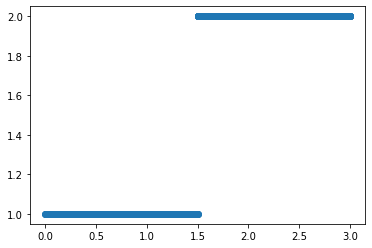

In [145]:
import matplotlib.pyplot as plt
# TODO optimales Netzwerk ermitteln
nlinear_nn = NeuralNetworkTorch()

nlinear_X = 3*torch.rand(2000).reshape(-1, 1)
nlinear_y = torch.clone(nlinear_X)
nlinear_y[nlinear_y>=1.5] = 2
nlinear_y[nlinear_y<1.5] = 1

nlinear_nn.train(nlinear_X, nlinear_y, epochs=100, batch_size=10, lr = 0.01)
nlinear_a_s = nlinear_nn.predict(nlinear_X)

plt.scatter(nlinear_X.flatten(), nlinear_y.flatten())
plt.scatter(nlinear_X.flatten(), nlinear_a_s.flatten())
plt.show()

In [ ]:
# TODO weitere optimale Netzwerke mit der PytorchImplementierung für die anderen Probleme ermitteln

# 2.4 Alternative Optimierungsalgorithmen

In [ ]:
# TODO weitere Optimierungsalgorithmen von Pytorch für die Probleme ausprobieren und bewerten